In [1]:
# 필요한 패키지 import 하는 코드
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from patsy import *

#  회귀분석 프로젝트 수행결과

> House Price 예측을 위한 선형회귀모델 구현

## [ 개 요 ]

#### ㅇ 선정 컨텐츠 : Kaggle House Prices: Advanced Regression Techniques
   * 컨텐츠 URL : https://www.kaggle.com/c/house-prices-advanced-regression-techniques
        
#### ㅇ 수행과제 목적 : 종속변수 'SalePrice'에 대한 선형회귀 예측모델 구현


#### ㅇ Dataset 구성 :
    1) 학습을 위한 train.csv 와 모델 TEST를 위한 test.csv

    2) column : ID, 종속변수 SalePrice, 독립변수 HeatingQC(house의 난방 퀄리티), YearBuilt(house가 지어진 년도) 등 총 80개로 구성
    
    3) row : 1460개 (test.csv : 1459개)

#### ㅇ 선형회귀 예측모델 구현요약

- 모델 성능측정 결과

    1) cross validation
    
      -> 평균 R-squared 0.92

    2) kaggle competition 
    
    
     - 정규선형회귀 미적용 모델 : 0.14787 Score , 4400 그룹 중 2637 rank 

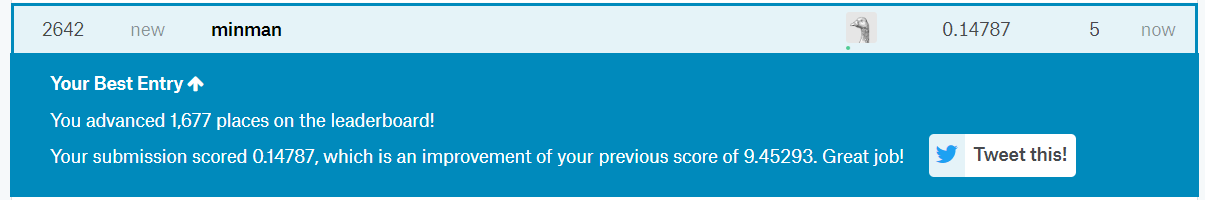

      - 정규선형회귀 적용모델 : 0.14632 Score / 4400 그룹 중 2560 rank 
      (alpha = 0.00009를 적용한 LASSO 모델)

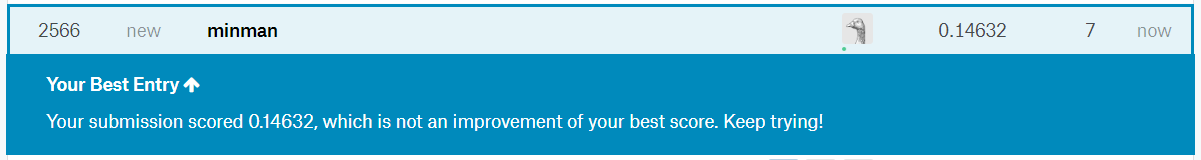

- 모델구성 기준

    1) condition number를 높이는 변수 제거
  
    2) 부분회귀플롯으로 상대적으로 높은 상관관계를 보이는 독립변수 채택

## [ 목 차 ]

### 1. '데이터 탐색 및 전처리' 결과

### 2. '선형회귀 예측모델 구현' 결과

----------------------------------------------------

## [  단계별 수행결과   ]

## 1. '데이터 탐색 및  전처리' 결과

#### * 칼럼별 description
- 집의 전체적인 모양새 (건축양식, 재료, 지어진 연도 ,지붕 스타일, 평가 점수, 울타리, 테라스 종류, 테라스 면적)
- 집 세부사항 (면적, 방 개수, 화장실 종류별 개수, 부엌 개수)
- Utility (난방여부, 난방방식, 전기, 벽난로)
- 주변위치를 고려한 특징 (단지, 도로까지의 거리, 경사, 인접도로 종류)
- 차고 (허용 대수, 면적, 연식, 평가 점수)
- 기타 사항 (매매 방식, 팔린 연도, 등)


#### 1) 범주형 col

- 순수한 범주형 col

MasVnrType

In [2]:
## train 데이터 로드
df = pd.read_csv("train.csv")

dmatrix("0+ C(MasVnrType)",df)

DesignMatrix with shape (1452, 4)
  Columns:
    ['C(MasVnrType)[BrkCmn]',
     'C(MasVnrType)[BrkFace]',
     'C(MasVnrType)[None]',
     'C(MasVnrType)[Stone]']
  Terms:
    'C(MasVnrType)' (columns 0:4)
  (to view full data, use np.asarray(this_obj))

- ordinal한 범주형 col

GarageQual

In [3]:
dmatrix("0+ C(GarageQual)",df)

DesignMatrix with shape (1379, 5)
  Columns:
    ['C(GarageQual)[Ex]',
     'C(GarageQual)[Fa]',
     'C(GarageQual)[Gd]',
     'C(GarageQual)[Po]',
     'C(GarageQual)[TA]']
  Terms:
    'C(GarageQual)' (columns 0:5)
  (to view full data, use np.asarray(this_obj))


#### 2) 실수형 col

- 실제 실수형 col

GarageArea

In [4]:
df['GarageArea'].tail()

1455    460
1456    500
1457    252
1458    240
1459    276
Name: GarageArea, dtype: int64

- 순수한 범주형 col

MSSubclass

In [5]:
dmatrix("0+ C(MSSubClass)",df)

DesignMatrix with shape (1460, 15)
  Columns:
    ['C(MSSubClass)[20]',
     'C(MSSubClass)[30]',
     'C(MSSubClass)[40]',
     'C(MSSubClass)[45]',
     'C(MSSubClass)[50]',
     'C(MSSubClass)[60]',
     'C(MSSubClass)[70]',
     'C(MSSubClass)[75]',
     'C(MSSubClass)[80]',
     'C(MSSubClass)[85]',
     'C(MSSubClass)[90]',
     'C(MSSubClass)[120]',
     'C(MSSubClass)[160]',
     'C(MSSubClass)[180]',
     'C(MSSubClass)[190]']
  Terms:
    'C(MSSubClass)' (columns 0:15)
  (to view full data, use np.asarray(this_obj))

### [ Issue ]

#### 1) 결측값은 어떻게 처리할 것인가

- 결측값 변수 변황 : 'PoolQC','MiscFeature' 등 19개

In [6]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(19)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


- 'MiscVal','MiscFeature','BsmtExposure','BsmtFinType2' 총 4개 변수 
   
   -> 최빈값으로 대체

In [7]:
df['BsmtExposure'][948] = 'No'
df['BsmtFinType2'][332] = 'Unf'

for i in range(len(df['MiscVal']+1)):
    if df['MiscVal'].values[i] == 0 and df['MiscFeature'].values[i] == 'Shed':
        df['MiscVal'].values[i] = df['MiscVal'][df['MiscVal'] != 0].mode()[0]

- 'LotFrontage' 변수

   -> 중앙값으로 대체

In [8]:
df['LotFrontage'].fillna(df.groupby('Neighborhood')['LotFrontage']\
                              .transform('median'), inplace=True)

- 그 외 결측값

   -> 범주형데이터는 'None', 실수형 데이터는 '0'으로 대체

In [9]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df[col].fillna('None',inplace=True)

df.fillna(0, inplace=True)

#### 2) 아웃라이어 제거


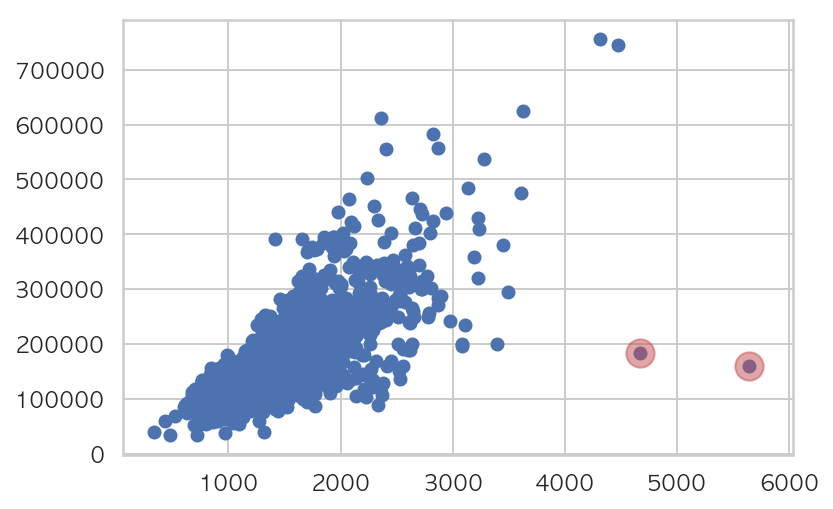

In [10]:
plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.scatter(df["GrLivArea"][523], df["SalePrice"][523], s=200, c='r', alpha = 0.5)
plt.scatter(df["GrLivArea"][1298], df["SalePrice"][1298], s=200, c='r', alpha = 0.5)

In [11]:
df = df.drop(df.index[1298])
df = df.drop(df.index[523])

### V 소결론 : 결측값 및 아웃라이어 제거로 선형회귀 예측모델의 구현을 위한 사전작업 수행

-----------------------------------------

## 2. '선형회귀 예측모델 구현' 결과

### [ Issue ]

#### 1) 80개에 달하는 독립변수 중 어떤 변수를 모델에 활용할 것인가
- 종속변수와 상관관계가 있는 독립변수 탐색
  
  -> 80개에 달하는 칼럼에 대해 순차적으로 탐색 & 토의
  
  
- boxplot, correlation heatmap을 이용 saleprice와 상관관계가 있는 독립변수를 채택
- 부분회귀플롯을 이용 상관관계가 있는 독립변수를 채택

#### 2) 최상의 Perfomance 성능구현을 위해 어떻게 할 것인가
- '독립변수 구성 재검토 <-> 모델구성' 반복시행으로 모델의 performance 향상시도
- kaggle contest summit으로 실질적인 모델의 performance 확인

#### 3) 모델의 신뢰성을 의심할만한 요소가 있지는 않은가
- 잔차정규성 검증 등 모델의 신뢰성 확인 
- 파이썬코드 구현상 오류발생여부 최종확인


### [ 선형회귀 예측모델 구현결과 ] 
-> 종속변수 SalePrice에 대한 StatsModels R스타일 선형회귀분석모델 도출

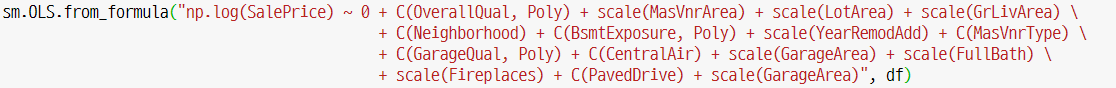

#### 1) 모델구성 :  'OverallQual' 등 15개의 독립변수 조합

- np.log(SalePrice) (종속변수) 
 
  -> 데이터가 정규분포로 가까워지도록 종속변수 제곱근 변수변환 조치


- scale(MasVnrArea) 등 실수형 데이터 8건 

  -> 변수별 데이터 수치범위가 상이하기 때문에 scale처리
  

- C(Neighborhood) 등 범주형 데이터 4건 

  -> 'C()' 연산자를 적용하여 범주형 데이터임을 명시적으로 지정
  
  
- C(OverallQual, Poly), C(GarageQual, Poly), C(BsmtExposure, Poly) 총 세건

  -> ordinal한 범주형 변수를 활용하기 위해 'category' 데이터 타입으로 변경, 'statsmodel Orthogonal Polynomial Coding' 처리

In [12]:
## OverallQual 변수 데이터 타입 'category' 으로 변경 
df['OverallQual'] = df["OverallQual"].astype('category')

## GarageQual 데이터 타입 'category' 으로 변경, 'statsmodel Orthogonal Polynomial Coding' 처리
df["GarageQual"] = df["GarageQual"].astype('category')
df["GarageQual"].cat.reorder_categories(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], inplace = True)
le = LabelEncoder()
le.fit(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
GarageQual_dict = {'None': 0, 'Po': 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' :5}
df["GarageQual"] = np.vectorize(GarageQual_dict.get)(df["GarageQual"])

## BsmtExposure 데이터 타입 'category' 으로 변경, 'statsmodel Orthogonal Polynomial Coding' 처리
df["BsmtExposure"] = df["BsmtExposure"].astype('category')
df['BsmtExposure'].cat.reorder_categories(['None', 'No', 'Mn', 'Av', 'Gd'], inplace=True)
le.fit(['None', 'No', 'Mn', 'Av', 'Gd'])
BsmtExposure_dict = {'None' : 0,'No' : 1, 'Mn' : 2, 'Av': 3, 'Gd' : 4}
df['BsmtExposure'] = np.vectorize(BsmtExposure_dict.get)(df['BsmtExposure'])

#### 2) 모델의 성능 확인
- model summary

In [13]:
model = sm.OLS.from_formula("np.log(SalePrice) ~ 0 + C(OverallQual, Poly) \
                            + scale(MasVnrArea) + scale(LotArea) + C(Neighborhood) + C(BsmtExposure, Poly) + scale(YearRemodAdd) \
                            + C(GarageQual, Poly) + C(MasVnrType) + C(CentralAir) + scale(GrLivArea) + scale(GarageArea) \
                            + scale(FullBath) + scale(Fireplaces) + C(PavedDrive) + scale(GarageArea)", df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     211.6
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        18:56:09   Log-Likelihood:                 894.53
No. Observations:                1458   AIC:                            -1677.
Df Residuals:                    1402   BIC:                            -1381.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
C(OverallQual, Poly).Constant      11.6806      0.058    203.035      0.000      11.568      11.793
C(OverallQual, Poly).Linear         0.9123      0.068     13.354      0.000       0.778       1.046
C(OverallQual, Poly).Quadratic     -0.0696      0.057     -1.213      0.225      -0.182       0.043
C(OverallQual, Poly).Cubic          0.0484      0.050      0.976      0.329      -0.049       0.146
C(OverallQual, Poly)^4              0.0293      0.049      0.595      0.552      -0.067       0.126
C(OverallQual, Poly)^5             -0.1488      0.047     -3.169      0.002      -0.241      -0.057
C(OverallQual, Poly)^6              0.0401      0.040      1.014      0.311      -0.038       0.118
C(OverallQual, Poly)^7             -0.0516      0.029     -1.795      0.073      -0.108       0.005
C(OverallQual, Poly)^8              0.0015      0.018      0.083      0.934      -0.034       0.037
C(OverallQual, Poly)^9             -0.0068      0.010     -0.662      0.508      -0.027       0.013
C(Neighborhood)[T.Blueste]         -0.1260      0.101     -1.244      0.214      -0.325       0.073
C(Neighborhood)[T.BrDale]          -0.2406      0.049     -4.861      0.000      -0.338      -0.144
C(Neighborhood)[T.BrkSide]         -0.0408      0.040     -1.010      0.313      -0.120       0.038
C(Neighborhood)[T.ClearCr]          0.0475      0.044      1.070      0.285      -0.040       0.135
C(Neighborhood)[T.CollgCr]          0.0353      0.035      0.997      0.319      -0.034       0.105
C(Neighborhood)[T.Crawfor]          0.1072      0.040      2.673      0.008       0.029       0.186
C(Neighborhood)[T.Edwards]         -0.0625      0.038     -1.629      0.104      -0.138       0.013
C(Neighborhood)[T.Gilbert]          0.0115      0.037      0.308      0.758      -0.062       0.085
C(Neighborhood)[T.IDOTRR]          -0.1976      0.043     -4.547      0.000      -0.283      -0.112
C(Neighborhood)[T.MeadowV]         -0.2414      0.049     -4.938      0.000      -0.337      -0.146
C(Neighborhood)[T.Mitchel]         -0.0114      0.040     -0.286      0.775      -0.090       0.067
C(Neighborhood)[T.NAmes]           -0.0106      0.037     -0.288      0.773      -0.083       0.061
C(Neighborhood)[T.NPkVill]         -0.0386      0.058     -0.669      0.503      -0.152       0.074
C(Neighborhood)[T.NWAmes]           0.0048      0.038      0.127      0.899      -0.070       0.079
C(Neighborhood)[T.NoRidge]          0.1050      0.042      2.505      0.012       0.023       0.187
C(Neighborhood)[T.NridgHt]          0.0983      0.039      2.522      0.012       0.022       0.175
C(Neighborhood)[T.OldTown]         -0.1465      0.039     -3.803      0.000      -0.222      -0.071
C(Neighborhood)[T.SWISU]           -0.0628      0.046     -1.377      0.169      -0

- Cross-validation

  -> 과최적화(overfitting)는 일어나지 않은 것으로 판단

In [14]:
## cross-validation 파이썬 코드 구현

df_test = df.copy()
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    cv_model = sm.OLS.from_formula("np.log(SalePrice) ~ 0 + C(OverallQual, Poly) \
                            + scale(MasVnrArea) + scale(LotArea) + C(Neighborhood) + C(BsmtExposure, Poly) + scale(YearRemodAdd) \
                            + C(GarageQual, Poly) + C(MasVnrType) + C(CentralAir) + scale(GrLivArea) + scale(GarageArea) \
                            + scale(FullBath) + scale(Fireplaces) + C(PavedDrive) + scale(GarageArea)"
                                , data=df_test.iloc[:, 1:])
    
    cv_result = cv_model.fit()
    
    pred = np.exp(cv_result.predict(df_test))
    rss = ((df_test.SalePrice - pred) ** 2).sum()
    tss = ((df_test.SalePrice - df_test.SalePrice.mean()) ** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("train R2 = {:.8f}, test R2 = {:.8f}".format(cv_result.rsquared, rsquared))

train R2 = 0.92595252, test R2 = 0.92479377
train R2 = 0.90179872, test R2 = 0.91127732
train R2 = 0.91237197, test R2 = 0.93109328
train R2 = 0.89836779, test R2 = 0.92725023
train R2 = 0.91624406, test R2 = 0.92415947


#### 3) 모델의 신뢰도 확인

- 실제값과 예측값 비교

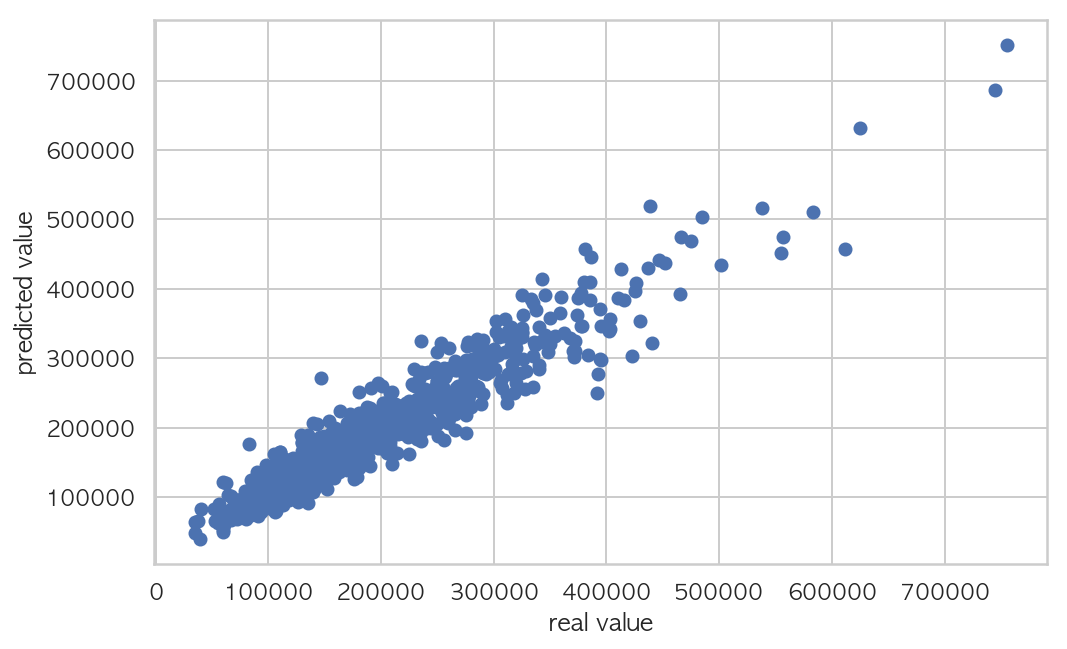

In [15]:
plt.figure(figsize=(8, 5))
plt.scatter(df['SalePrice'], np.exp(result.predict(df)))
plt.xlabel('real value')
plt.ylabel('predicted value')
plt.show()

- 실제값과 예측값의 상관계수

In [16]:
df['SalePrice'].corr(np.exp(result.predict(df)))

0.9539567137232117

- 잔차정규성 검증

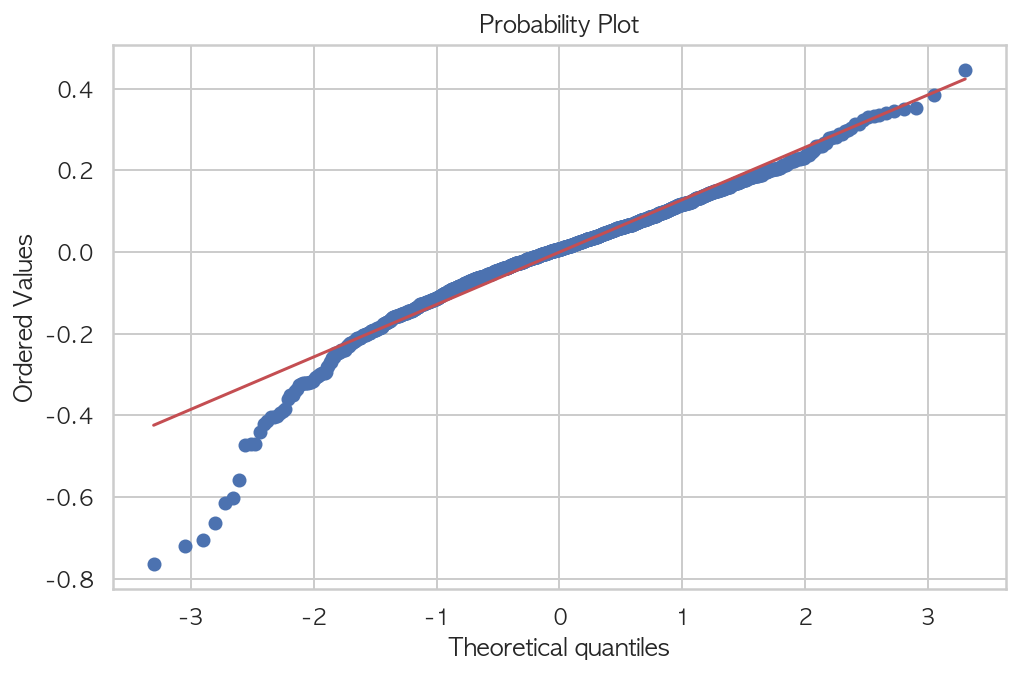

In [17]:
# Q-Q plot
plt.figure(figsize=(8, 5))
sp.stats.probplot(result.resid, plot=plt)
plt.show()

### V 결론 : 신뢰성과 Performance를 균형있게 고려한 선형회귀 예측모델 구현 달성